In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection

import scipy.stats as st
from scipy.stats import ks_2samp

import seaborn as sns

from sklearn import decomposition
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

from scipy.cluster.hierarchy import linkage, fcluster
from sklearn import preprocessing

from functions import *

from scipy.cluster.hierarchy import dendrogram

In [2]:
def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

# 1. Création du dataframe nécessaire à l'analyse

In [3]:
#importation des fichiers
pop = pd.read_csv('population.csv')
animaux = pd.read_csv('animal.csv')
vege = pd.read_csv('vegetal.csv')

In [4]:
pop = pop.rename(columns={"Code zone" : "Code zone (FAO)"})

Le df "pop" contient les données concernant le nombre d'habitants en 2016 et 2017. Nous allons donc créer la croissance de la population entre ces deux années.

In [5]:
pop = pop[['Code zone (FAO)', 'Zone', 'Année', 'Valeur']]
pop = pop.loc[(pop['Année'] == 2016) | (pop['Année'] == 2017)]
pop['croissance_pop'] = round(pop.groupby('Zone')['Valeur'].pct_change()*100,2)
pop = pop.dropna()
pop = pop.rename(columns={"Valeur" : "nb_habitants"})
pd.set_option('display.max_columns', None)
pop

,Code zone (FAO),Zone,Année,nb_habitants,croissance_pop
1,2,Afghanistan,2017,36296.113,2.58
3,202,Afrique du Sud,2017,57009.756,1.43
5,3,Albanie,2017,2884.169,-0.08
7,4,Algérie,2017,41389.189,2.07
9,79,Allemagne,2017,82658.409,0.57
...,...,...,...,...,...
463,236,Venezuela (République bolivarienne du),2017,29402.484,-1.50
465,237,Viet Nam,2017,94600.648,1.03
467,249,Yémen,2017,27834.819,2.45
469,251,Zambie,2017,16853.599,3.00


Nous pouvons également ajouter les df "animaux" et "vege" contenant les informations sur la disponbilité alimentaire de chaque pays.

In [6]:
animaux['origine'] = 'animale'
vege['origine'] = 'vegetale'
bilan_alim = animaux.append(vege)
bilan_alim = bilan_alim[['Code zone (FAO)', 'Zone', 'Code Produit', 'Produit', 'Élément', 'Année', 'Valeur', 'origine']]
bilan_alim = pd.pivot_table(bilan_alim, index=['Code zone (FAO)', 'Zone', 'Code Produit', 'Produit', 'Année', 'origine'], columns= 'Élément', values='Valeur', aggfunc=np.sum).reset_index()
bilan_alim = bilan_alim.rename(columns = {'Disponibilité intérieure' : 'dispo_int', 
                                          'Disponibilité alimentaire (Kcal/personne/jour)' : 'dispo_kcal_p_j',
                                          'Disponibilité alimentaire en quantité (kg/personne/an)' : 'dispo_kg_p',
                                          'Disponibilité de matière grasse en quantité (g/personne/jour)' : 'dispo_mat_g_p_j',
                                          'Disponibilité de protéines en quantité (g/personne/jour)' : 'dispo_prot_g_p_j'})
bilan_alim.head()

Élément,Code zone (FAO),Zone,Code Produit,Produit,Année,origine,dispo_kcal_p_j,dispo_kg_p,dispo_mat_g_p_j,dispo_prot_g_p_j,dispo_int
0,1,Arménie,2511,Blé et produits,2017,vegetale,1154.0,145.43,4.28,34.36,547.0
1,1,Arménie,2513,Orge et produits,2017,vegetale,4.0,0.51,0.02,0.14,107.0
2,1,Arménie,2514,Maïs et produits,2017,vegetale,0.0,0.05,0.00,0.01,59.0
3,1,Arménie,2515,Seigle et produits,2017,vegetale,1.0,0.14,0.01,0.03,1.0
4,1,Arménie,2516,Avoine,2017,vegetale,7.0,0.65,0.12,0.26,7.0


In [7]:
bilan_alim = pd.pivot_table(bilan_alim, index=['Code zone (FAO)', 'Zone'], columns='origine', values=['dispo_prot_g_p_j', 'dispo_kcal_p_j'], aggfunc=np.sum).reset_index(level=[0])
columns = bilan_alim.columns
new_index = pd.Index([e[0] + e[1] for e in columns.tolist()])
bilan_alim.columns = new_index
bilan_alim = bilan_alim.rename(columns={'dispo_kcal_p_janimale' : 'dispo_kcal_p_j_anim',
                                        'dispo_kcal_p_jvegetale' : 'dispo_kcal_p_j_veg',
                                        'dispo_prot_g_p_janimale' : 'dispo_prot_p_j_anim',
                                        'dispo_prot_g_p_jvegetale' : 'dispo_prot_p_j_veg'})

# Calcul de proportion de protéines animales dans la disponiblité alimentaire en protéines totale
bilan_alim['prot_anim'] = round((bilan_alim['dispo_prot_p_j_anim']/(bilan_alim['dispo_prot_p_j_anim'] + bilan_alim['dispo_prot_p_j_veg']))*100, 2)
bilan_alim.head()

,Code zone (FAO),dispo_kcal_p_j_anim,dispo_kcal_p_j_veg,dispo_prot_p_j_anim,dispo_prot_p_j_veg,prot_anim
Zone,,,,,,
Arménie,1,805.0,2259.0,45.72,51.91,46.83
Afghanistan,2,195.0,1852.0,11.16,44.99,19.88
Albanie,3,1048.0,2341.0,64.21,53.89,54.37
Algérie,4,420.0,2914.0,26.77,65.80,28.92
Angola,7,213.0,2156.0,16.34,35.59,31.47


In [8]:
# On joins les différents dataframes afin de créer un df unique
df = pd.merge(bilan_alim, pop, on=['Zone', 'Code zone (FAO)'])

In [9]:
# On supprime les dataframes population et bilan_alim pour éviter d'avoir des doublons
del bilan_alim
del pop

In [10]:
# On calcule la disponibilité alimentaire en protéines par habitant (en g)
df['prot_hab'] = (df['dispo_prot_p_j_anim'] + df['dispo_prot_p_j_veg']) * 365

In [11]:
# On calcule la disponibilité alimentaire en calories par habitant
df['kcal_hab'] = (df['dispo_kcal_p_j_anim'] + df['dispo_kcal_p_j_veg']) * 365

In [12]:
df = df.rename(columns={"Zone" : 'pays'})
df = df.drop(columns = {'Code zone (FAO)', 'Année', 'nb_habitants', 'dispo_kcal_p_j_anim', 'dispo_kcal_p_j_veg', 'dispo_prot_p_j_anim', 'dispo_prot_p_j_veg'})
df.head()

,pays,prot_anim,croissance_pop,prot_hab,kcal_hab
0,Arménie,46.83,0.29,35634.95,1118360.0
1,Afghanistan,19.88,2.58,20494.75,747155.0
2,Albanie,54.37,-0.08,43106.50,1236985.0
3,Algérie,28.92,2.07,33788.05,1216910.0
4,Angola,31.47,3.38,18954.45,864685.0


In [13]:
# On importe le dataframe contenant le PIB par habitant en 2017
pib = pd.read_csv('pib.csv')

In [14]:
pib = pib[['Zone', 'Valeur']]
pib = pib.rename(columns={'Zone' : 'pays',
                          'Valeur' : 'PIB'})
pib.head()

,pays,PIB
0,Afghanistan,513.085978
1,Afrique du Sud,6121.876572
2,Albanie,4514.204908
3,Algérie,4109.701336
4,Allemagne,44552.061000


In [15]:
# On joint les deux dataframes afin d'obtenir un dataframe unique appelé "data"
data = pd.merge(df, pib, on = 'pays')
data.head()

,pays,prot_anim,croissance_pop,prot_hab,kcal_hab,PIB
0,Arménie,46.83,0.29,35634.95,1118360.0,3914.525246
1,Afghanistan,19.88,2.58,20494.75,747155.0,513.085978
2,Albanie,54.37,-0.08,43106.50,1236985.0,4514.204908
3,Algérie,28.92,2.07,33788.05,1216910.0,4109.701336
4,Angola,31.47,3.38,18954.45,864685.0,4095.811686


In [16]:
# On reprend notre dataframe contenant les données sur les produits d'origine animal et on ne séléctionne que la viande de volailles
animaux = pd.read_csv('animal.csv')
animaux = animaux[animaux['Produit'] == 'Viande de Volailles']
animaux = pd.pivot_table(animaux, index=['Code zone (FAO)', 'Zone'], columns='Élément', values = 'Valeur', aggfunc=np.sum).reset_index()
animaux.head()

Élément,Code zone (FAO),Zone,Disponibilité alimentaire (Kcal/personne/jour),Disponibilité alimentaire en quantité (kg/personne/an),Disponibilité de matière grasse en quantité (g/personne/jour),Disponibilité de protéines en quantité (g/personne/jour),Disponibilité intérieure
0,1,Arménie,52.0,15.38,3.25,5.21,45.0
1,2,Afghanistan,5.0,1.57,0.34,0.56,57.0
2,3,Albanie,59.0,11.45,4.46,4.44,33.0
3,4,Algérie,25.0,7.35,1.73,2.26,304.0
4,7,Angola,34.0,10.20,2.14,3.48,304.0


In [17]:
# On joint avec notre dataframe final "data" et on calcule la proportion de protéines provenant de la viande de volailles
animaux = animaux.rename(columns = {'Zone' : 'pays'})
data = pd.merge(data, animaux, on = 'pays')
data['prot_volaille'] = round((data['Disponibilité de protéines en quantité (g/personne/jour)'] * 365) / data['prot_hab']*100,2)
data = data[['pays','croissance_pop', 'PIB', 'prot_anim', 'prot_hab', 'prot_volaille', 'kcal_hab']]
data = data.fillna(0)
data.head()

,pays,croissance_pop,PIB,prot_anim,prot_hab,prot_volaille,kcal_hab
0,Arménie,0.29,3914.525246,46.83,35634.95,5.34,1118360.0
1,Afghanistan,2.58,513.085978,19.88,20494.75,1.00,747155.0
2,Albanie,-0.08,4514.204908,54.37,43106.50,3.76,1236985.0
3,Algérie,2.07,4109.701336,28.92,33788.05,2.44,1216910.0
4,Angola,3.38,4095.811686,31.47,18954.45,6.70,864685.0


In [18]:
pd.set_option('max_rows', None)
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 172 entries, 0 to 171
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   pays            172 non-null    object 
 1   croissance_pop  172 non-null    float64
 2   PIB             172 non-null    float64
 3   prot_anim       172 non-null    float64
 4   prot_hab        172 non-null    float64
 5   prot_volaille   172 non-null    float64
 6   kcal_hab        172 non-null    float64
dtypes: float64(6), object(1)
memory usage: 10.8+ KB


# 2. Dendrogramme

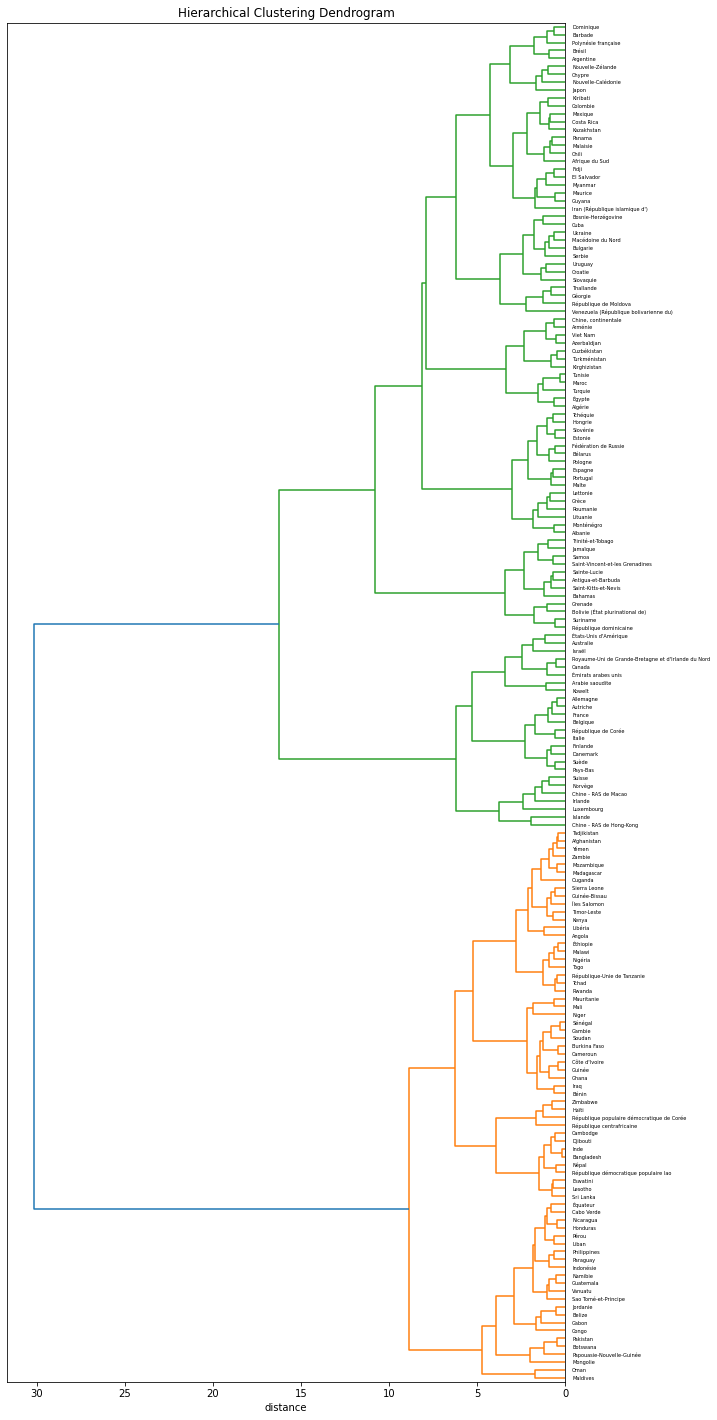

In [19]:
#Préparation des données pour le clustering:
X = data.iloc[:,1:].values
names = data.pays.tolist()

std_scaler = preprocessing.StandardScaler().fit(X)
X_scaled = std_scaler.transform(X)

#Clustering hiérarchique:
Z = linkage(X_scaled, 'ward')

plot_dendrogram(Z, names)
plt.show()

In [20]:
# Coupage du dendrogramme en 5 clusters
clusters = fcluster(Z, 5, criterion='maxclust')
data['cluster']=clusters

In [21]:
#On enregistre le fichier CSV contenant chaque pays muni du cluster auquel il a été attribué:
liste_pays=data.set_index("pays")
liste_pays=liste_pays.iloc[:, [6]]
liste_pays.to_csv('P5_03_listepays.csv')

# 3. K-means

In [22]:
data.set_index('pays',inplace=True)

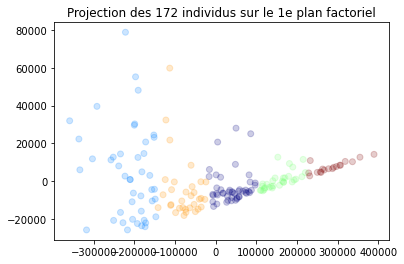

In [23]:
# Nombre de clusters souhaités
n_clust = 5

# préparation des données pour le clustering
X = data.values

# Clustering par K-means
km = KMeans(n_clusters=n_clust)
km.fit(X)

# Récupération des clusters attribués à chaque individu
clusters2 = km.labels_

# Affichage du clustering par projection des individus sur le premier plan factoriel
pca = decomposition.PCA(n_components=5).fit(X)
X_projected = pca.transform(X)
plt.scatter(X_projected[:, 0], X_projected[:, 1], c=clusters2.astype(np.float), cmap = 'jet', alpha=.2)
plt.title("Projection des {} individus sur le 1e plan factoriel".format(X_projected.shape[0]))
plt.show(block=False)

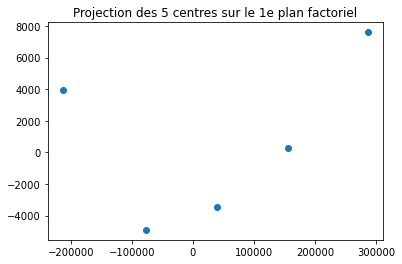

In [24]:
# Affichage des positions des centres de classes
plt.figure()
centroids = km.cluster_centers_
centroids_projected = pca.transform(centroids)
plt.scatter(centroids_projected[:,0],centroids_projected[:,1])
plt.title("Projection des {} centres sur le 1e plan factoriel".format(len(centroids)))
plt.show()

In [25]:
data=data.reset_index()

In [26]:
#Affichage des centres de classes pour chacun des clusters

df_clust=data.drop(columns="pays")
clust = pd.DataFrame(df_clust.groupby("cluster").mean())
clust.to_csv("P5_04_centroïdes.csv")

clust

,croissance_pop,PIB,prot_anim,prot_hab,prot_volaille,kcal_hab
cluster,,,,,,
1,2.089130,4977.937087,41.744348,25067.089130,7.526957,9.426046e+05
2,2.314894,1436.944147,22.558085,22163.576596,2.271064,8.772736e+05
3,0.938800,52919.577159,59.937200,39913.188000,10.486400,1.259892e+06
4,0.761667,11477.748443,56.595000,28441.408333,21.902500,9.863821e+05
5,0.472923,11566.759236,49.004462,33193.773846,9.220154,1.126800e+06


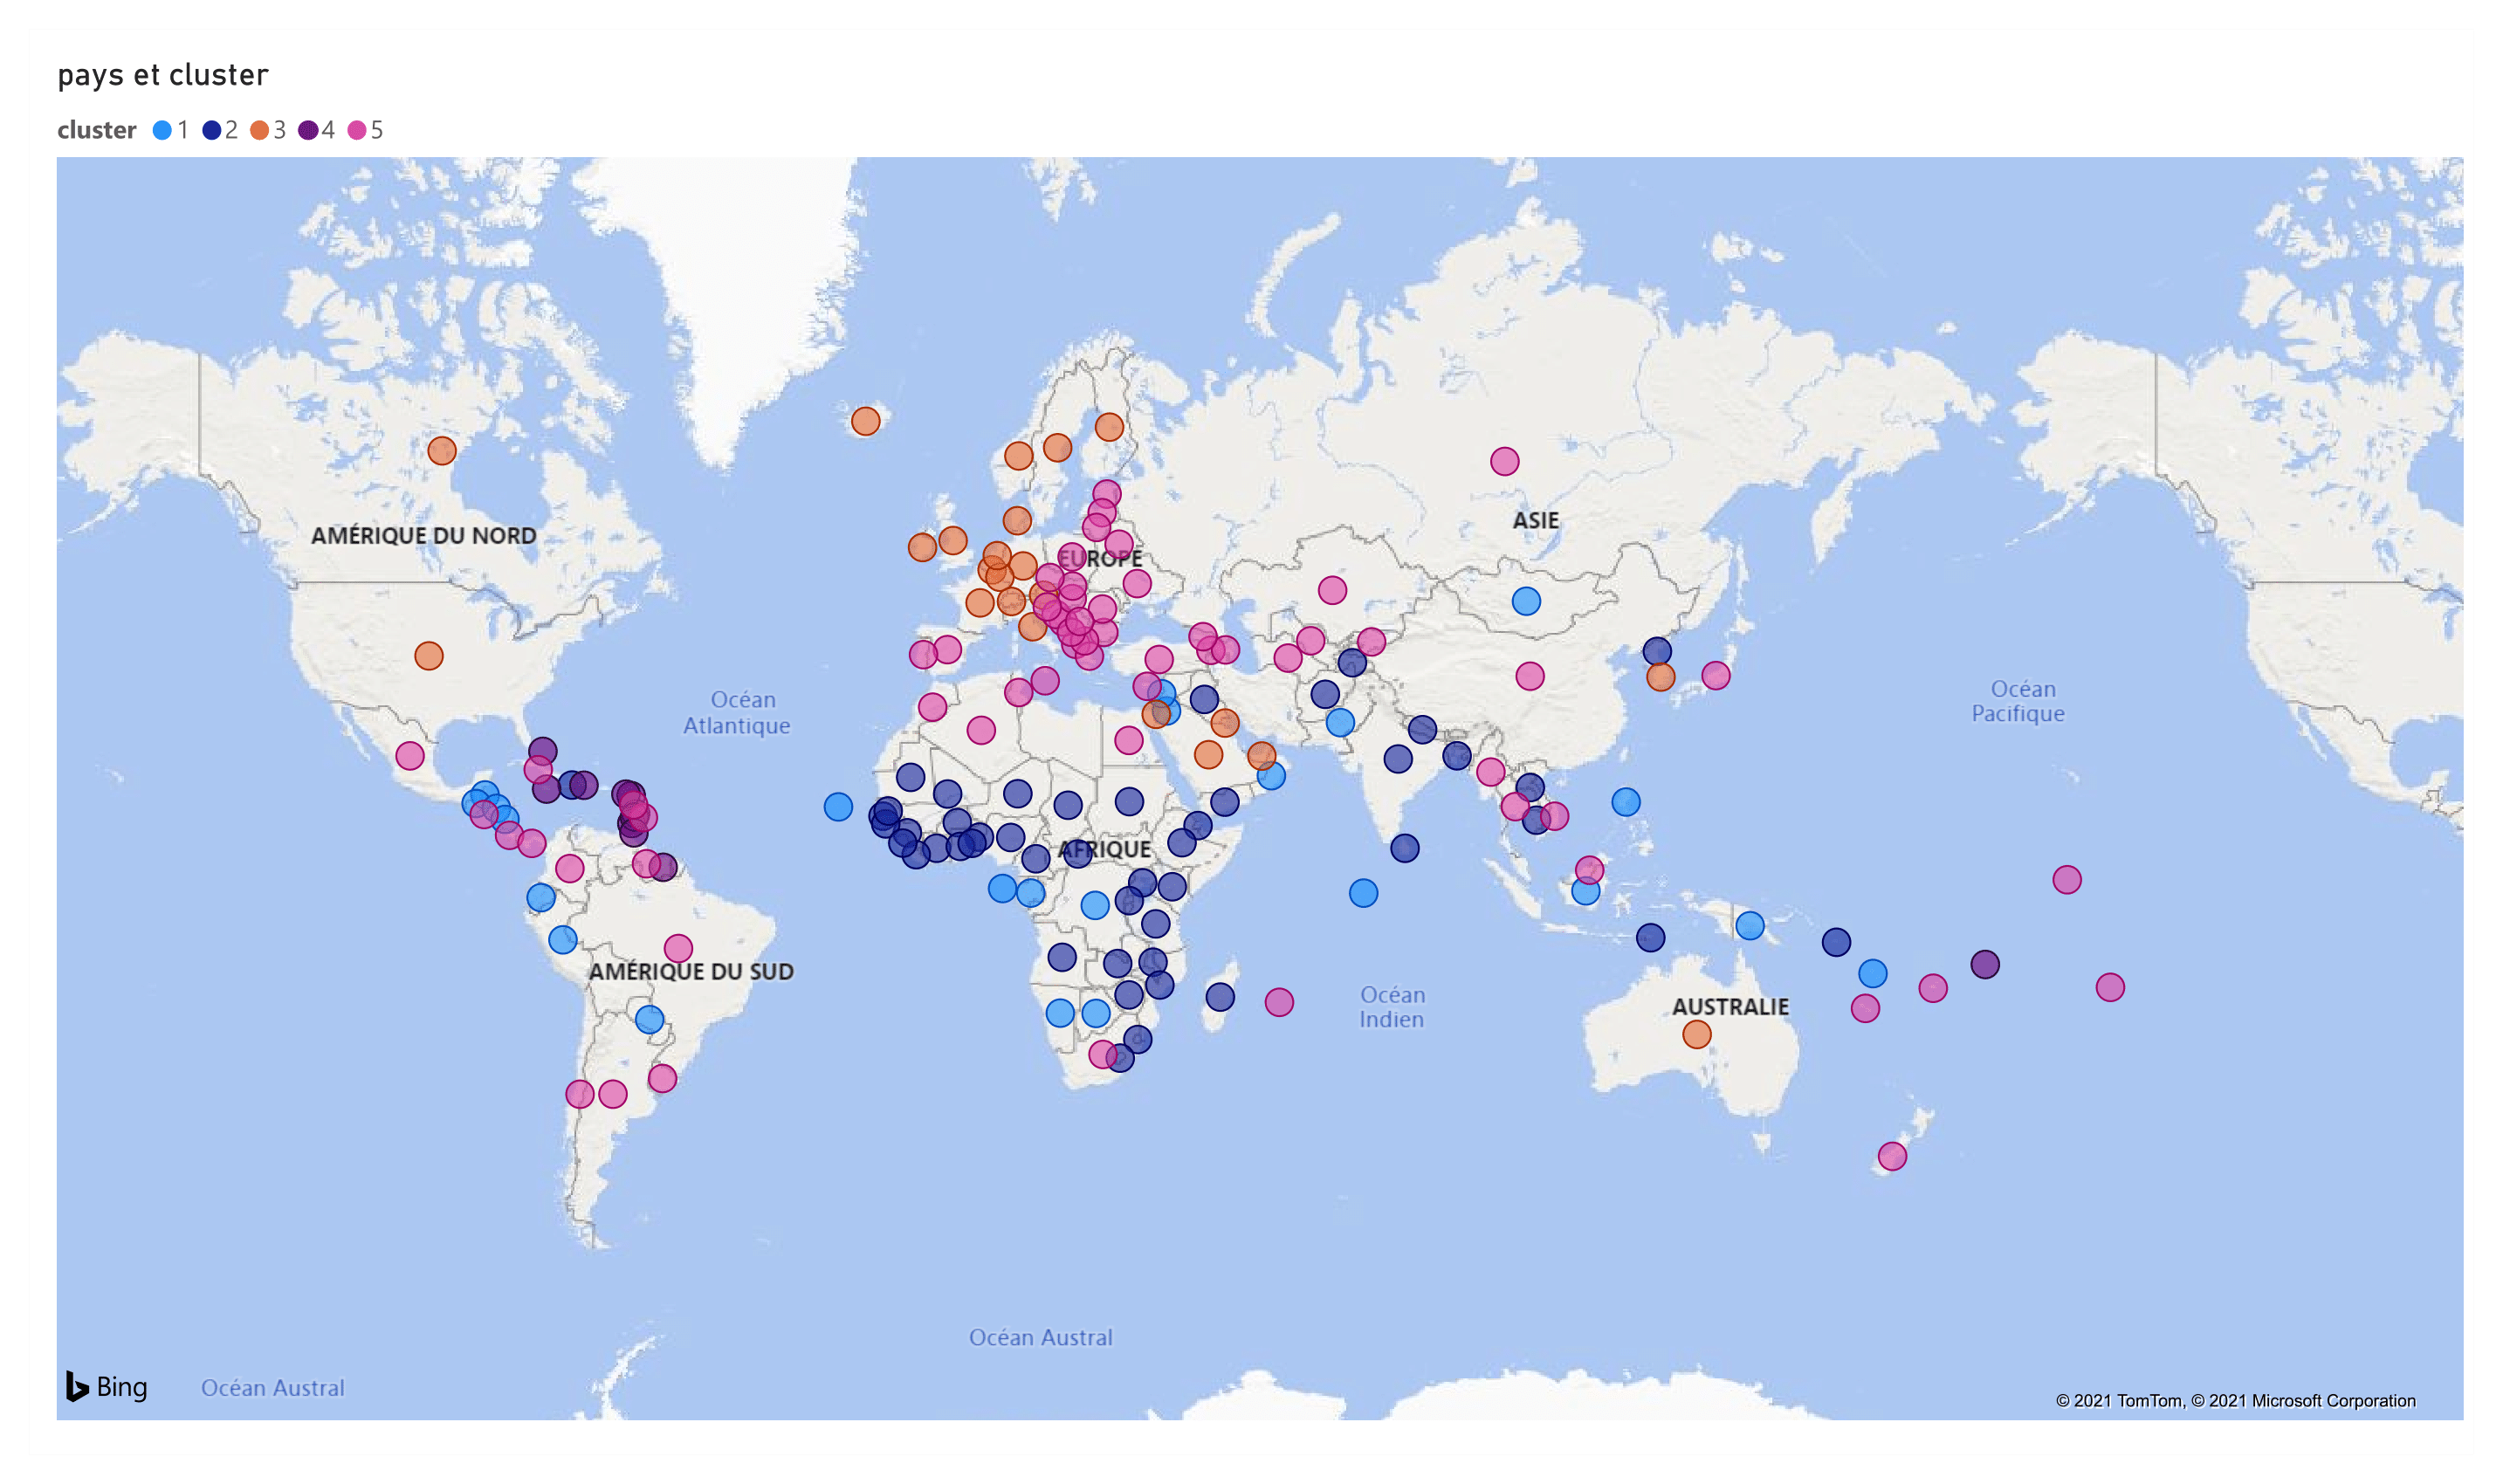
<i>Carte faite avec PowerBI</i>

<ul>
<li>Cluster 1 : 23 pays. On y trouve des pays assez variés, avec certains pays d'Afrique, d'Amerique Latine du Moyen-Orient et quelques îles d'Océanie. On y constate une croissance de la population assez importante et un PIB par habitant plutôt faible.  La disponibilité alimentaire n'est pas conséquente et ces pays ne réunissent pas les critères nécessaires à une internationalisation de l'entreprise. Nous n'allons pas retenir ce cluster.</li></ul>

<ul>    
<li>Cluster 2 : 47 pays.  On retrouve principalement les pays d'Afrique subsaharienne et certaines pays d'Asie comme l'Inde. La croissance de la population y est très importante ce qui indique un renouvellement de la clientèle significatif. La disponibilité alimentaire est cependant très faible. De plus, il s'agit du cluster avec le PIB moyen par habitant le plus bas. Nous n'allons pas retenir ce cluster dans nos analyses.</li></ul>

<ul>    
<li>Cluster 3 : 25 pays. Il s'agit du cluster avec les pays les plus riches et développés du monde : les pays de l'Union Européenne, les Etats-Unis, L'Australie et les Emirats Arabe Unis, entre autres. La croissance de la population y est peu importante, la situation démographique ne permet pas un renouvellement de la clientèle assez conséquent. Cependant la disponbilité alimentaire y est très élevée et le PIB traduit une forte capacité d'achat et de consommation des habitants. De plus, ces pays ont déjà des relations commerciales solides et bien établies avec la France. Il serait judicieux de d'abord privilégier ici les pays européens qui regroupent tout d'abord une proximité avec la France qui facilite la logistique et des conditions commerciales grâce à leur appartenance à l'UE très avantageuses. Nous allons retenir ce cluster.</li></ul>
    
<ul><li>Cluster 4 : 12 pays. Il s'agit du plus petit cluster constitué d'îles de l'Atlantique et du Pacifique. On y retrouve une croissance de la population et et un PIB par habitant plutôt moyen. La disponibilité alimentaire y est cependant assez conséquente, surtout la proportion de protéines issue de la viande de volailles et la taille des pays suggèrent que la plupart des produits nécessaire à l'alimentation sont importés. Cependant, pour une première "tentative" d'exportation des produits, il n'est pas conseillé de se tourner vers ce cluster.</li></ul>

<ul><li>Cluster 5 : 65 pays. Il s'agit du plus gros cluster avec les pays de l'Europe de l'est, du Maghreb, certains pays d'Amérique Latine, La Chine, et d'autres pays d'Asie comme le Vietnam. Il s'agit du cluster avec la croissance de la population la plus faible mais un PIB et une disponibilité alimentaire assez importants. Ce sont des pays qui se développent  Nous allons retenir ce cluster tout en privilégiant tout de même les pays du cluster 3.</li>
</ul>

In [27]:
# Création d'une copie du dataframe "data" afin de réaliser l'ACP
data_acp=data.copy()
clusters = fcluster(Z, 5, criterion='maxclust')
data_acp["cluster"]=clusters
data_acp.head(4)

,pays,croissance_pop,PIB,prot_anim,prot_hab,prot_volaille,kcal_hab,cluster
0,Arménie,0.29,3914.525246,46.83,35634.95,5.34,1118360.0,5
1,Afghanistan,2.58,513.085978,19.88,20494.75,1.00,747155.0,2
2,Albanie,-0.08,4514.204908,54.37,43106.50,3.76,1236985.0,5
3,Algérie,2.07,4109.701336,28.92,33788.05,2.44,1216910.0,5


In [28]:
data.set_index('pays', inplace = True)

<b>Combien de composantes à analyser ?</b>

Après avoir réaliser une première ACP avec 6 composantes, j'ai choisi de ne conserver que les composantes F1 et F2 en me basant sur le critère de Kaiser.

<b>Critère de Kaiser</b> : on ne retient que les axes dont l’inertie est supérieure à l’inertie moyenne (100/p)% avec p = 6 : (100/6) = 16.6%. 
Le premier axe conserve 61.4% de l’inertie du nuage. Il est peu probable qu’il soit dû au hasard. Le second axe conserve une part importante de l’inertie totale, 15.2%. 

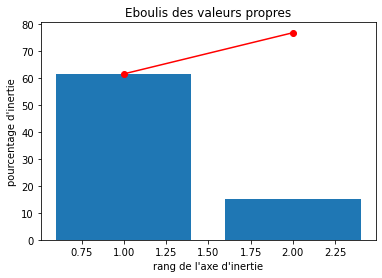

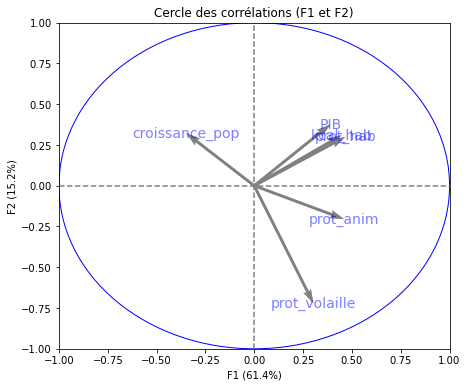

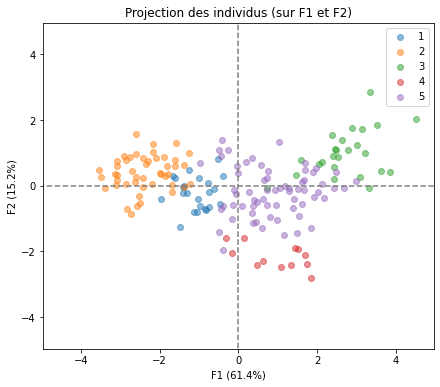

In [29]:
# choix du nombre de composantes à calculer
n_comp = 2

# selection des colonnes à prendre en compte dans l'ACP
data_pca = data_acp[['croissance_pop', 'prot_anim', 'prot_hab', 'kcal_hab', 'PIB', 'prot_volaille']]

data_pca = data_pca.fillna(data_pca.mean()) # Il est fréquent de remplacer les valeurs inconnues par la moyenne de la variable
X = data_pca.values
names = data_pca.index # ou data.index pour avoir les intitulés
features = data_pca.columns

# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)

# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_
display_circles(pcs, n_comp, pca, [(0,1)], labels = np.array(features))

# Projection des individus
X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var = data_acp['cluster'], alpha = 0.5)

plt.show()

La croissance de la population contribue fortement à la formation de la composante F2. La composante F1 réunit surtout les variables concernant la disponiblité alimentaire. On observe également une possible corrélation entre le PIB et la disponibilité alimentaire en protéines et en calories par habitant. Cette corrélation semble logique : plus le PIB est important, plus l'accès à l'alimentation est facilité.

In [30]:
composantes=pd.DataFrame(pca.fit_transform(X_scaled), index=data.index)
composantes.columns=["F1", "F2"]
composantes.head(4)

,F1,F2
pays,,
Arménie,0.644729,0.181565
Afghanistan,-3.074531,0.328860
Albanie,1.696453,0.699909
Algérie,-0.411169,1.380198


In [31]:
data_acp.set_index('pays')

,croissance_pop,PIB,prot_anim,prot_hab,prot_volaille,kcal_hab,cluster
pays,,,,,,,
Arménie,0.29,3914.525246,46.83,35634.95,5.34,1118360.0,5
Afghanistan,2.58,513.085978,19.88,20494.75,1.00,747155.0,2
Albanie,-0.08,4514.204908,54.37,43106.50,3.76,1236985.0,5
Algérie,2.07,4109.701336,28.92,33788.05,2.44,1216910.0,5
Angola,3.38,4095.811686,31.47,18954.45,6.70,864685.0,2
Antigua-et-Barbuda,0.95,15383.415188,64.93,29210.95,23.43,890235.0,4
Argentine,0.99,14627.615635,64.03,38562.25,13.54,1192455.0,5
Australie,1.33,57628.863849,67.47,38357.85,16.76,1241000.0,3
Autriche,0.83,47306.411842,59.53,39190.05,6.98,1345025.0,3


# 4. Tests statistiques

### 4.1 Test d'adéquation : le test de Kolmogorov Smirnov

Les variables étudiées étant continue, c'est le test de Kolmogorov Smirnov qui sera appliqué ici.

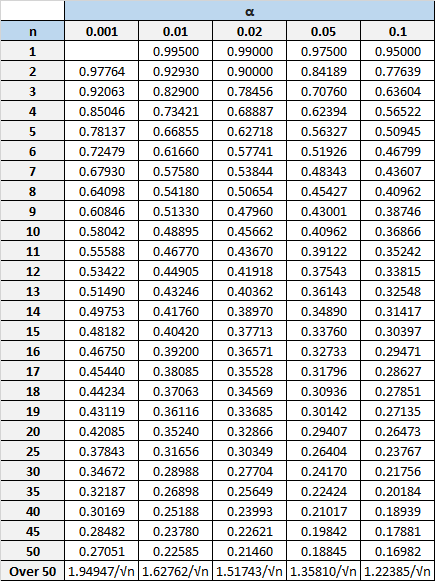

#### 4.1.1 Proportion de protéines animales

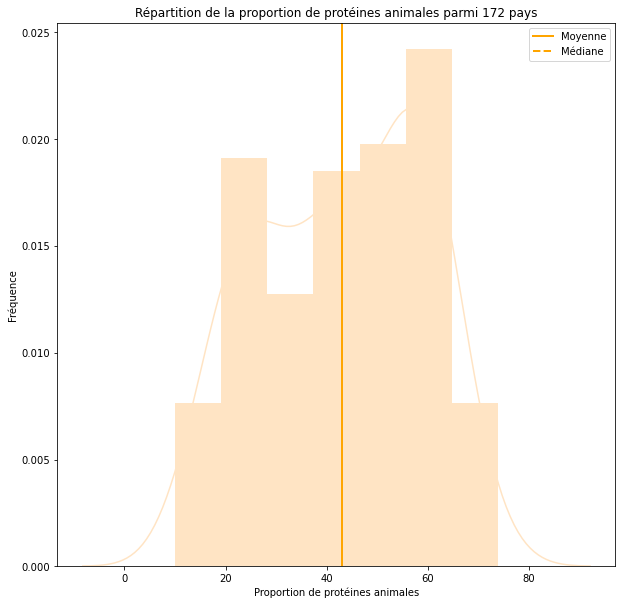

In [32]:
plt.figure(figsize = (10,10))

sns.distplot(data['prot_anim'],
                  kde=True,
                  color='bisque',
                  hist_kws={"linewidth": 15, 'alpha':1})
plt.axvline(x=data['prot_anim'].mean(), label='Moyenne', linestyle='-', linewidth=2, color="orange")
plt.axvline(x=data['prot_anim'].median(), label='Médiane', linestyle='--', linewidth=2, color="orange")
plt.xlabel('Proportion de protéines animales')
plt.ylabel('Fréquence')
plt.title('Répartition de la proportion de protéines animales parmi 172 pays')
plt.legend()

plt.savefig('Distribution_prot_anim')

plt.show()

In [33]:
ks_2samp(data["prot_anim"],list(np.random.normal(np.mean(data["prot_anim"]), np.std(data["prot_anim"]), 1000)))

KstestResult(statistic=0.07765116279069767, pvalue=0.3203034470614472)

<b>D = 0.077</b>
<p>Or pour un échantillon N = 172 et un coefficient $\alpha =$ 0.05, on obtient 1.358$\div\sqrt172 =$ 0.10. </p>
0.077 < 0.10 alors H0 est vraie. On peut donc dire que la proportion de protéines animales suit la loi normale.

#### 4.1.2 Croissance de la population entre 2016 et 2017

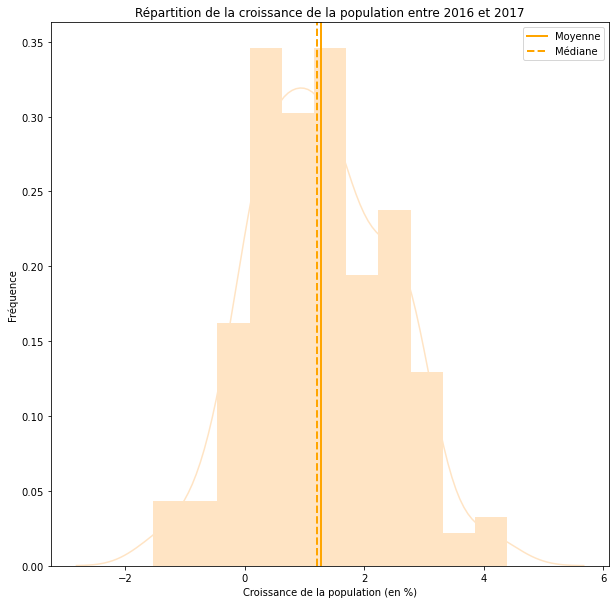

In [34]:
plt.figure(figsize = (10,10))

sns.distplot(data["croissance_pop"],
                  kde=True,color='bisque',
                  hist_kws={"linewidth": 15,'alpha':1})
plt.axvline(x=data["croissance_pop"].mean(), label='Moyenne', linestyle='-', linewidth=2, color="orange")
plt.axvline(x=data["croissance_pop"].median(), label='Médiane', linestyle='--', linewidth=2, color="orange")
plt.xlabel('Croissance de la population (en %)')
plt.ylabel('Fréquence')
plt.title('Répartition de la croissance de la population entre 2016 et 2017')
plt.legend()

plt.savefig('Distribution_croissance_pop')

plt.show()

In [35]:
ks_2samp(data["croissance_pop"],list(np.random.normal(np.mean(data["croissance_pop"]), np.std(data["croissance_pop"]), 1000)))

KstestResult(statistic=0.08411627906976744, pvalue=0.23500924081528862)

<b>D = 0.08</b>
<p>Or pour un échantillon N = 172 et un coefficient $\alpha =$ 0.05, on obtient 1.358$\div\sqrt172 =$ 0.10. </p>
0.08 < 0.10 alors H0 est vraie. On peut donc dire que la croissance de la population suit la loi normale.

#### 4.1.3 Disponibilité alimentaire en protéines par habitant

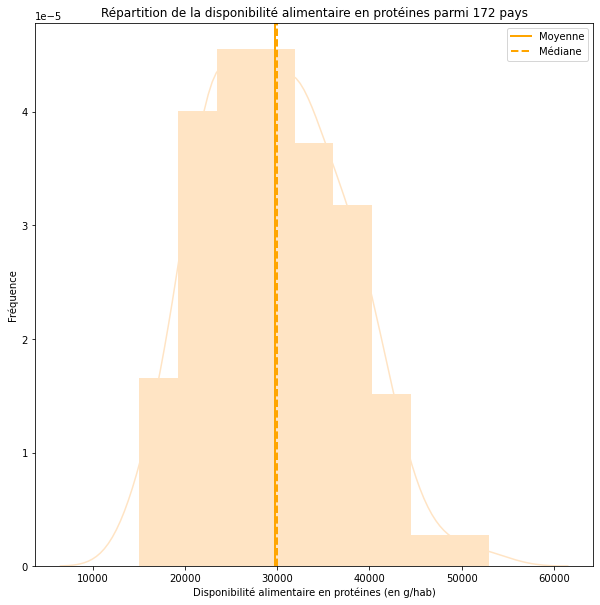

In [36]:
plt.figure(figsize = (10,10))

sns.distplot(data["prot_hab"],
                  kde=True,color='bisque',
                  hist_kws={"linewidth": 15,'alpha':1})
plt.axvline(x=data["prot_hab"].mean(), label='Moyenne', linestyle='-', linewidth=2, color="orange")
plt.axvline(x=data["prot_hab"].median(), label='Médiane', linestyle='--', linewidth=2,color="orange")
plt.xlabel('Disponibilité alimentaire en protéines (en g/hab)')
plt.ylabel('Fréquence')
plt.title('Répartition de la disponibilité alimentaire en protéines parmi 172 pays')
plt.legend()

plt.savefig('Distribution_prot')

plt.show()

In [37]:
ks_2samp(data["prot_hab"],list(np.random.normal(np.mean(data["prot_hab"]), np.std(data["prot_hab"]), 1000)))

KstestResult(statistic=0.055953488372093026, pvalue=0.7232610673196114)

<b>D = 0.05</b>
<p>Or pour un échantillon N = 172 et un coefficient $\alpha =$ 0.05, on obtient 1.358$\div\sqrt172 =$ 0.10. </p>
0.05 < 0.10 alors H0 est vraie. On peut donc dire que la disponibilité alimentaire en protéines suit la loi normale.

#### 4.1.4 Disponiblité alimentaire en calories par habitant

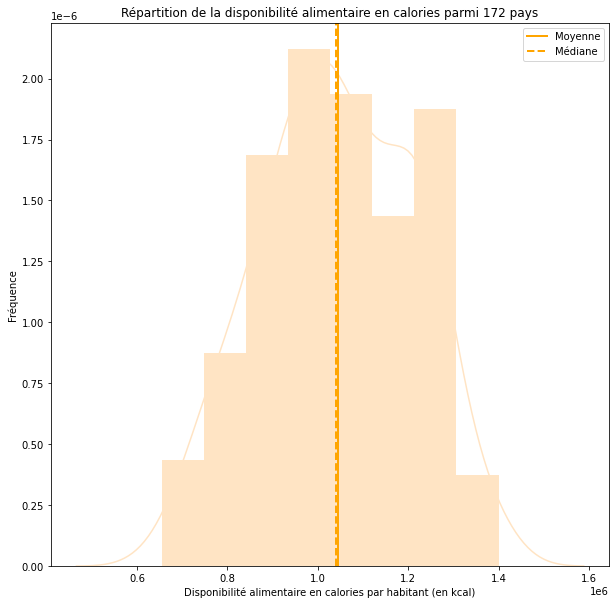

In [38]:
plt.figure(figsize = (10,10))

sns.distplot(data["kcal_hab"],
                  kde=True,color='bisque',
                  hist_kws={"linewidth": 15,'alpha':1})
plt.axvline(x=data["kcal_hab"].mean(), label='Moyenne', linestyle='-', linewidth=2, color='orange')
plt.axvline(x=data["kcal_hab"].median(), label='Médiane', linestyle='--', linewidth=2, color='orange')
plt.xlabel('Disponibilité alimentaire en calories par habitant (en kcal)')
plt.ylabel('Fréquence')
plt.title('Répartition de la disponibilité alimentaire en calories parmi 172 pays')
plt.legend()

plt.savefig('Distribution_kcal.jpg')

plt.show()

In [39]:
ks_2samp(data["kcal_hab"],list(np.random.normal(np.mean(data["kcal_hab"]), np.std(data["kcal_hab"]), 1000)))

KstestResult(statistic=0.0728139534883721, pvalue=0.3965739519781092)

<b>D = 0.07</b>
<p>Or pour un échantillon N = 172 et un coefficient $\alpha =$ 0.05, on obtient 1.358$\div\sqrt172 =$ 0.10. </p>
0.07 < 0.10 alors H0 est vraie. On peut donc dire que disponibilité alimentaire en calories suit la loi normale.

#### 4.1.5 PIB par habitant

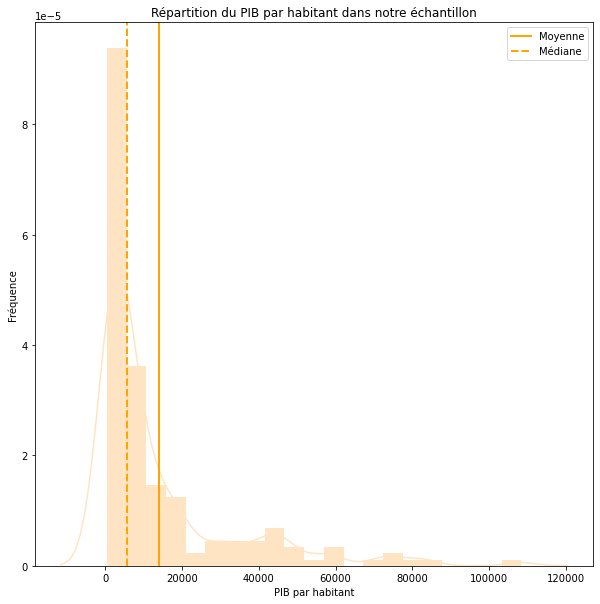

In [69]:
plt.figure(figsize = (10,10))

sns.distplot(data["PIB"],
                  kde=True,color='bisque',
                  hist_kws={"linewidth": 15,'alpha':1})
plt.axvline(x=data["PIB"].mean(), label='Moyenne', linestyle='-', linewidth=2,color='orange')
plt.axvline(x=data["PIB"].median(), label='Médiane', linestyle='--', linewidth=2,color='orange')
plt.xlabel('PIB par habitant')
plt.ylabel('Fréquence')
plt.title('Répartition du PIB par habitant dans notre échantillon')
plt.legend()

plt.savefig('Distribution_PIB.jpg')

plt.show()

In [41]:
ks_2samp(data["PIB"],list(np.random.normal(np.mean(data["PIB"]), np.std(data["PIB"]), 1000)))

KstestResult(statistic=0.25109302325581395, pvalue=1.2386655701135396e-08)

<b>D = 0.2</b>
<p>Or pour un échantillon N = 172 et un coefficient $\alpha =$ 0.05, on obtient 1.358$\div\sqrt172 =$ 0.10. </p>
0.2 > 0.10 alors l'hypothèse H0 peut être rejetée. On peut donc dire que le PIB par habitant ne suit pas la loi normale.

#### 4.1.6 Proportion de protéines issue de la viande de volailles

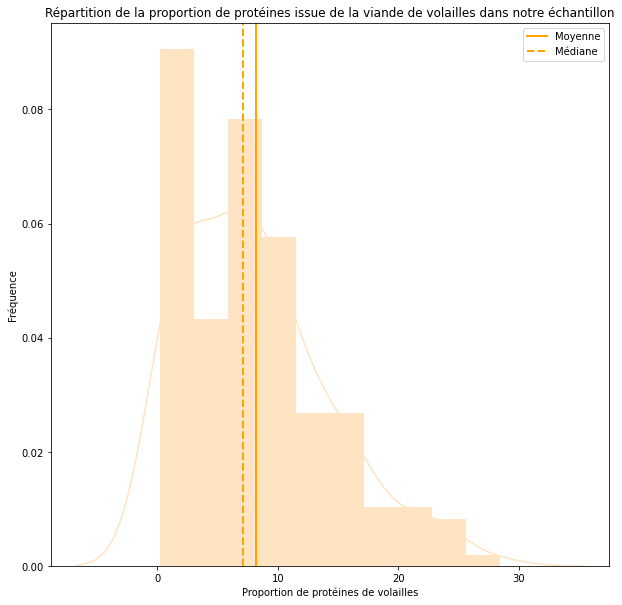

In [42]:
plt.figure(figsize = (10,10))

sns.distplot(data["prot_volaille"],
                  kde=True,color='bisque',
                  hist_kws={"linewidth": 15,'alpha':1})
plt.axvline(x=data["prot_volaille"].mean(), label='Moyenne', linestyle='-', linewidth=2,color='orange')
plt.axvline(x=data["prot_volaille"].median(), label='Médiane', linestyle='--', linewidth=2,color='orange')
plt.xlabel('Proportion de protéines de volailles')
plt.ylabel('Fréquence')
plt.title('Répartition de la proportion de protéines issue de la viande de volailles dans notre échantillon')
plt.legend()

plt.savefig('Distribution_volaille.jpg')

plt.show()

In [67]:
ks_2samp(data["prot_volaille"],list(np.random.normal(np.mean(data["prot_volaille"]), np.std(data["prot_volaille"]), 1000)))

KstestResult(statistic=0.091, pvalue=0.16421933111588038)

<b>D = 0.09</b>
<p>Or pour un échantillon N = 172 et un coefficient $\alpha =$ 0.05, on obtient 1.358$\div\sqrt172 =$ 0.10. </p>
0.09 < 0.10 alors H0 est vraie. On peut donc dire que la proportion de protéines issue de la viande de volailles suit la loi normale.

### 4.2 Test de comparaison : égalités des variances et des moyennes

#### 4.2.1 Proportion de protéines issue de la viande de volailles

In [44]:
clust3=data[data["cluster"]==3]["prot_volaille"]
clust5=data[data["cluster"]==5]["prot_volaille"]

In [45]:
st.bartlett(clust3,clust5)

BartlettResult(statistic=0.32905375906733525, pvalue=0.566216800937747)

In [46]:
st.ttest_ind(clust3,clust5, equal_var=True)

Ttest_indResult(statistic=1.2452296190384091, pvalue=0.21635299362028346)

#### 4.2.2 Proportion de protéines animales

In [47]:
clust3=data[data["cluster"]==3]["prot_anim"]
clust5=data[data["cluster"]==5]["prot_anim"]

In [48]:
st.bartlett(clust3,clust5)

BartlettResult(statistic=1.4964386020930964, pvalue=0.22122015533814834)

In [49]:
st.ttest_ind(clust3,clust5, equal_var=True)

Ttest_indResult(statistic=4.777731971458898, pvalue=7.038418160728584e-06)

#### 4.2.3 Disponiblité alimentaire en calories par habitant

In [50]:
clust3=data[data["cluster"]==3]["kcal_hab"]
clust5=data[data["cluster"]==5]["kcal_hab"]

In [51]:
st.bartlett(clust3,clust5)

BartlettResult(statistic=5.786107506566081, pvalue=0.01615331744424934)

In [52]:
st.ttest_ind(clust3,clust5, equal_var=True)

Ttest_indResult(statistic=6.016952359950024, pvalue=3.985014591308652e-08)

#### 4.2.4 Disponibilité alimentaire en protéines par habitant

In [68]:
clust3=data[data["cluster"]==3]["prot_hab"]
clust5=data[data["cluster"]==5]["prot_hab"]

In [54]:
st.bartlett(clust3,clust5)

BartlettResult(statistic=0.41834266225253214, pvalue=0.5177651841228188)

In [55]:
st.ttest_ind(clust3,clust5, equal_var=True)

Ttest_indResult(statistic=5.842970842333964, pvalue=8.492436062289393e-08)

#### 4.2.5 Croissance de la population entre 2016 et 2017

In [56]:
clust3=data[data["cluster"]==3]["croissance_pop"]
clust5=data[data["cluster"]==5]["croissance_pop"]

In [57]:
st.bartlett(clust3,clust5)

BartlettResult(statistic=2.342995100934823, pvalue=0.12584738133316423)

In [58]:
st.ttest_ind(clust3,clust5, equal_var=True)

Ttest_indResult(statistic=2.451942774363043, pvalue=0.016183834497292555)

#### 4.2.6 PIB par habitant

In [59]:
clust3=data[data["cluster"]==3]["PIB"]
clust5=data[data["cluster"]==5]["PIB"]

In [60]:
st.stats.mannwhitneyu(clust3,clust5)

MannwhitneyuResult(statistic=22.0, pvalue=5.532556117145372e-13)

# 5. Les pays choisis

In [61]:
df_final=data.copy()
df_final["F1"]=composantes["F1"]
df_final["F2"]=composantes["F2"]

In [62]:
df_final=df_final.loc[df_final['cluster'].isin(['3','5'])]
df_final

,croissance_pop,PIB,prot_anim,prot_hab,prot_volaille,kcal_hab,cluster,F1,F2
pays,,,,,,,,,
Arménie,0.29,3914.525246,46.83,35634.95,5.34,1118360.0,5,0.644729,0.181565
Albanie,-0.08,4514.204908,54.37,43106.50,3.76,1236985.0,5,1.696453,0.699909
Algérie,2.07,4109.701336,28.92,33788.05,2.44,1216910.0,5,-0.411169,1.380198
Argentine,0.99,14627.615635,64.03,38562.25,13.54,1192455.0,5,1.932712,-0.345513
Australie,1.33,57628.863849,67.47,38357.85,16.76,1241000.0,3,3.080682,0.252379
Autriche,0.83,47306.411842,59.53,39190.05,6.98,1345025.0,3,2.643086,1.398106
Barbade,0.15,17392.010677,58.96,31576.15,17.37,1059595.0,5,1.499327,-1.450503
Brésil,0.81,9925.419442,56.46,34350.15,16.44,1185885.0,5,1.539325,-0.917494
Bulgarie,-0.69,8300.173316,48.58,31130.85,10.24,1031125.0,5,0.815535,-0.961210


In [63]:
df_final["inertie"]=0.614*df_final['F1']+0.152*df_final['F2']
df_final=df_final.sort_values(by="F1", ascending=False)
df_final.head(10)

,croissance_pop,PIB,prot_anim,prot_hab,prot_volaille,kcal_hab,cluster,F1,F2,inertie
pays,,,,,,,,,,
Islande,0.66,73231.725965,73.08,52946.90,8.51,1331520.0,3,4.509693,2.027894,3.077191
États-Unis d'Amérique,0.64,60116.568493,64.83,41281.50,17.67,1377510.0,3,3.866252,0.402590,2.435072
Chine - RAS de Hong-Kong,0.87,46705.027813,73.80,49596.20,14.48,1192455.0,3,3.637811,0.454260,2.302664
Irlande,1.22,71391.006104,60.74,42099.10,9.87,1399410.0,3,3.519645,1.842330,2.441096
Luxembourg,2.18,108431.931751,62.67,39814.20,6.61,1259250.0,3,3.347087,2.852071,2.488626
Israël,1.66,42850.548478,58.52,45771.00,22.19,1299400.0,3,3.310390,-0.066965,2.022401
Danemark,0.37,57938.797728,66.13,42153.85,9.72,1239905.0,3,3.228394,0.986342,2.132158
Norvège,0.86,75220.814442,62.48,41412.90,7.47,1230050.0,3,3.138159,1.731651,2.190040
Australie,1.33,57628.863849,67.47,38357.85,16.76,1241000.0,3,3.080682,0.252379,1.929900


Nous pouvons supprimer les deux territoires chinois et réactualiser la liste.

In [64]:
df_final=df_final.reset_index()
df_final=df_final.loc[(df_final.pays!="Chine - RAS de Hong-Kong") 
                  & (df_final.pays!="Chine - RAS de Macao")]

df_final=df_final.set_index("pays")
df_final.head(10)

,croissance_pop,PIB,prot_anim,prot_hab,prot_volaille,kcal_hab,cluster,F1,F2,inertie
pays,,,,,,,,,,
Islande,0.66,73231.725965,73.08,52946.90,8.51,1331520.0,3,4.509693,2.027894,3.077191
États-Unis d'Amérique,0.64,60116.568493,64.83,41281.50,17.67,1377510.0,3,3.866252,0.402590,2.435072
Irlande,1.22,71391.006104,60.74,42099.10,9.87,1399410.0,3,3.519645,1.842330,2.441096
Luxembourg,2.18,108431.931751,62.67,39814.20,6.61,1259250.0,3,3.347087,2.852071,2.488626
Israël,1.66,42850.548478,58.52,45771.00,22.19,1299400.0,3,3.310390,-0.066965,2.022401
Danemark,0.37,57938.797728,66.13,42153.85,9.72,1239905.0,3,3.228394,0.986342,2.132158
Norvège,0.86,75220.814442,62.48,41412.90,7.47,1230050.0,3,3.138159,1.731651,2.190040
Australie,1.33,57628.863849,67.47,38357.85,16.76,1241000.0,3,3.080682,0.252379,1.929900
Lituanie,-1.53,16784.459812,60.28,46241.85,7.69,1249030.0,5,2.989351,0.131104,1.855389


Voici la liste finale des pays séléctionnés pour le projet d'exportation des produits. Il serait tout de même judicieux de privilégier les pays européens dans un premier temps offrant des avantages economiques non négligeable.
<ul>
<li>Bonne relations commerciales avec la France</li>
<li>Situation politique stable</li>
<li>Logistique facilitée</li>
<li>Libre échange au sein de l'UE</li>
<li>Logistique facilitée</li></ul>
    
De plus, il serait aussi intéressant d'étudier plus en profondeur dans un second temps les pays européens et du Moyen-Orient du cluster 5 : Chypre, Estonie, Koweït, Malte, Pologne, Portugal, Arabie Saoudite… 